In [5]:
# ML_Prediction.ipynb
# Purpose: Predict PM2.5 levels in Ulaanbaatar using ML models
# Structure: Data loading → Feature engineering → Modeling → Evaluation
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set(style='whitegrid')

# ==============================================================
# 1. Load and Clean Data
# ==============================================================
pre_url = "https://raw.githubusercontent.com/Undran/Mongolia-AirPollution-CoalBan/refs/heads/main/data/openaq_pre2019.csv"
post_url = "https://raw.githubusercontent.com/Undran/Mongolia-AirPollution-CoalBan/refs/heads/main/data/openaq_post2019.csv"

pre_data = pd.read_csv(pre_url)
post_data = pd.read_csv(post_url)
df = pd.concat([pre_data, post_data], ignore_index=True)

# Filter PM2.5 only
if 'parameter' in df.columns:
    df = df[df['parameter'].str.lower().str.contains('pm25', na=False)]

# Clean values
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df = df[(df['value'].notna()) & (df['value'] != -999)]

# Parse datetime
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'], utc=True, errors='coerce')
df = df.dropna(subset=['datetimeUtc']).sort_values(['location_name','datetimeUtc']).reset_index(drop=True)

# Add year/period labels
df['year'] = df['datetimeUtc'].dt.year
df['period'] = np.where(df['year'] < 2019, 'pre', 'post')

print("Dataset shape after cleaning:", df.shape)
print(df[['datetimeUtc','location_name','value']].head())


Dataset shape after cleaning: (1682, 17)
                datetimeUtc location_name  value
0 2016-11-09 18:00:00+00:00   Ulaanbaatar   30.3
1 2016-11-09 19:00:00+00:00   Ulaanbaatar   24.6
2 2016-11-09 20:00:00+00:00   Ulaanbaatar   35.3
3 2016-11-09 21:00:00+00:00   Ulaanbaatar   36.6
4 2016-11-09 22:00:00+00:00   Ulaanbaatar   29.8


In [6]:
# 2. Feature Engineering
# ==============================================================
df['month'] = df['datetimeUtc'].dt.month
df['dayofyear'] = df['datetimeUtc'].dt.dayofyear

# Cyclical month encoding
df['month_sin'] = np.sin(2*np.pi*df['month']/12.0)
df['month_cos'] = np.cos(2*np.pi*df['month']/12.0)

# Location encoding
le = LabelEncoder()
df['location_encoded'] = le.fit_transform(df['location_name'].astype(str))

# Lag + rolling mean features
df = df.sort_values(['location_name','datetimeUtc'])
df['lag1'] = df.groupby('location_name')['value'].shift(1)
df['lag7'] = df.groupby('location_name')['value'].shift(7)
df['rolling_mean_7'] = (
    df.groupby('location_name')['value']
    .shift(1)
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Drop NaNs created by lagging
df = df.dropna(subset=['lag1','lag7','rolling_mean_7'])


In [7]:
# 3. Train / Test Split (Pre-2019 → Train, Post-2019 → Test)
# ==============================================================
train = df[df['period']=="pre"].copy()
test  = df[df['period']=="post"].copy()

features = ['month_sin','month_cos','dayofyear','location_encoded','lag1','lag7','rolling_mean_7']
target = 'value'

X_train, y_train = train[features], train[target]
X_test,  y_test  = test[features],  test[target]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (864, 7) Test size: (811, 7)


In [8]:
# 4. Models and Justification
# ==============================================================
print("\nSelected models:")
print("- Linear Regression: simple, interpretable baseline.")
print("- Random Forest: nonlinear, robust to noise, interpretable via feature importance.")
print("- Gradient Boosting: improves accuracy via boosting weak learners.")
print("- XGBoost: efficient gradient boosting widely used in prediction tasks.\n")

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbosity=0)
}



Selected models:
- Linear Regression: simple, interpretable baseline.
- Random Forest: nonlinear, robust to noise, interpretable via feature importance.
- Gradient Boosting: improves accuracy via boosting weak learners.
- XGBoost: efficient gradient boosting widely used in prediction tasks.



In [9]:
# 5. Cross-Validation on Training Data
# ==============================================================
tscv = TimeSeriesSplit(n_splits=5)

def rmse_cv(model, X, y):
    scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_mean_squared_error")
    return np.sqrt(-scores)

for name, model in models.items():
    scores = rmse_cv(model, X_train, y_train)
    print(f"{name}: CV RMSE mean={scores.mean():.2f}, std={scores.std():.2f}")


LinearRegression: CV RMSE mean=132.73, std=21.73
RandomForest: CV RMSE mean=131.96, std=33.33
GradientBoosting: CV RMSE mean=147.69, std=43.09
XGBoost: CV RMSE mean=151.45, std=44.80


In [11]:
# 6. Hyperparameter Tuning (Example: Random Forest)
# ==============================================================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Best RF params:", grid_search.best_params_)

# Replace RF with tuned one
models['RandomForest'] = grid_search.best_estimator_


Best RF params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [14]:
# 7. Train Final Models & Evaluate on Test Data
# ==============================================================
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "MAPE (%)": mape,
        "Train Time (s)": round(t1-t0,2)
    })

results_df = pd.DataFrame(results).sort_values("RMSE")
print("\n=== Test Set Evaluation ===")
display(results_df)


Training LinearRegression...

Training RandomForest...

Training GradientBoosting...

Training XGBoost...

=== Test Set Evaluation ===


,Model,RMSE,MAE,R²,MAPE (%),Train Time (s)
1,RandomForest,85.597765,57.297501,0.560427,inf,1.04
0,LinearRegression,89.344586,70.255955,0.521102,inf,0.00
2,GradientBoosting,92.587366,62.252040,0.485708,inf,0.59
3,XGBoost,98.031870,66.899890,0.423445,inf,0.81


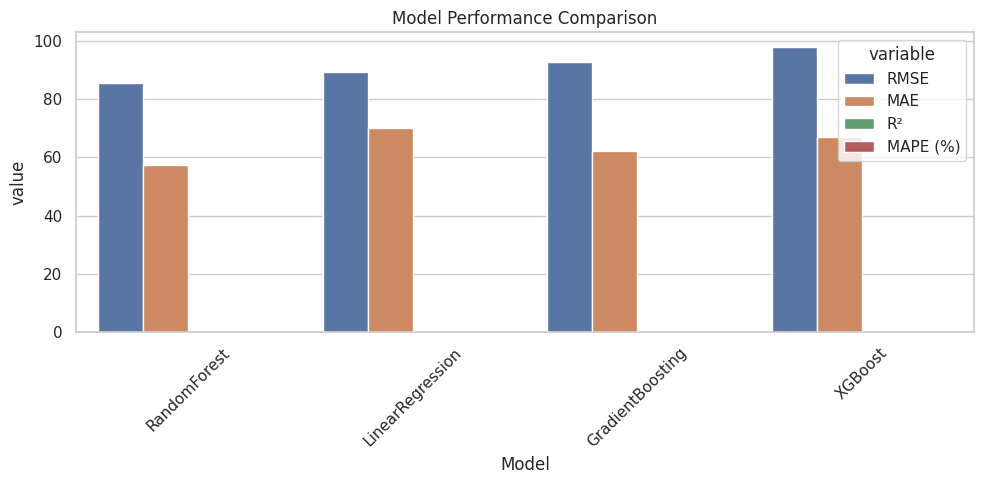

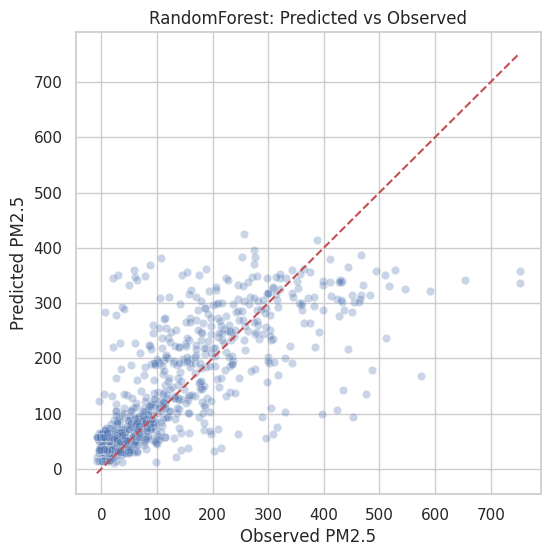

/tmp/ipython-input-1453837768.py:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  test_copy['year_month'] = test_copy['datetimeUtc'].dt.to_period('M')


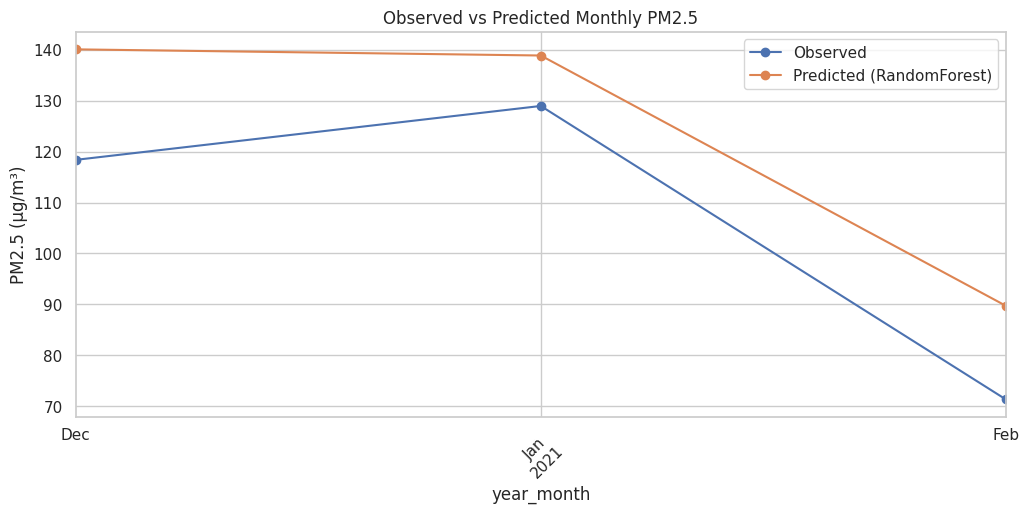

In [13]:
# 8. Visualization
# ==============================================================
# Barplot of metrics
melted = results_df.melt(id_vars="Model", value_vars=["RMSE","MAE","R²","MAPE (%)"])
plt.figure(figsize=(10,5))
sns.barplot(data=melted, x="Model", y="value", hue="variable")
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Best model scatter vs observed
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Observed PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title(f"{best_model_name}: Predicted vs Observed")
plt.show()

# Monthly averages observed vs predicted
test_copy = test.loc[X_test.index].copy()
test_copy['pred'] = y_pred_best
test_copy['year_month'] = test_copy['datetimeUtc'].dt.to_period('M')

monthly_obs = test_copy.groupby('year_month')['value'].mean()
monthly_pred = test_copy.groupby('year_month')['pred'].mean()

plt.figure(figsize=(12,5))
monthly_obs.plot(label="Observed", marker="o")
monthly_pred.plot(label=f"Predicted ({best_model_name})", marker="o")
plt.legend()
plt.title("Observed vs Predicted Monthly PM2.5")
plt.ylabel("PM2.5 (µg/m³)")
plt.xticks(rotation=45)
plt.show()